# Entrainement de modèles de classification textuelle


<div style="display: inline; float: left">
  <img src="https://www.quinzaine-cineastes.fr/storage/wsm_medias/affiche_film_dydWPWEaJlbgbbcPWUN0wiJlpFJnoV14SEzK9f8t.jpeg?ncache=11" alt="img" width="200" align="right"/>
  <p style="float: left; font-size: 30px;">  
Nous allons voir aujourd'hui comment entrainer des classifieurs textuels, en utilisant des embeddings de mots pour représenter le contenu d'un texte, avec trois méthodes différentes:

1. A partir d'embeddings statiques
précalculés (type word2vec, glove).
2. Avec des embeddings entrainés de zéro en même temps que le modèle de classification.
3. Avec des modèles contextuels pré-entrainés (type Bert/GPT).

Nous prendrons comme exemple de tâches la classification de sentiments, avec le jeu de données IMDB https://huggingface.co/datasets/stanfordnlp/imdb
  </p>
</div>


Ce **TP sera à rendre sur moodle au plus tard le 25/11/2024**, les questions qui vous sont posées sont indiquées **en gras**.

**⛔ Vous devez compléter/ajouter du code et analyser vos résultats selon les différents réglages que vous avez essayés**

# 1. A partir d'embeddings statiques précalculés






On reprend en partie le TD sur les embeddings statiques

In [ ]:
!pip install gensim

In [ ]:
import gensim
from tqdm import tqdm

In [ ]:
# small glove
import gensim.downloader as api
model = api.load("glove-wiki-gigaword-100") #50, 100, 200, 300

[==================================================] 100.0% 128.1/128.1MB downloaded


In [ ]:
vocabulary = model.key_to_index
#print(len(vocabulary))

In [ ]:
import numpy as np
import string
punct_remove = str.maketrans('', '',string.punctuation)

In [ ]:
# fonction d'encodage de phrase = moyenne des embeddings des mots (possible correction du TD)
def encode(sentence,model):
  vocabulary = set(model.key_to_index)
  words = sentence.lower().translate(punct_remove)
  words = words.split()
  vector = model[[word for word in words if word in vocabulary]].mean(axis=0)
  return vector


In [ ]:
%timeit encode("This is a very short test.",model)

32.4 ms ± 1.47 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Le jeu de données
En TD on avait regardé ce jeu de données
(paraphrases):

PAWS: Paraphrase Adversaries from Word Scrambling: https://huggingface.co/datasets/google-research-datasets/paws

On va cette fois considérer l'analyse de "sentiment", sur des critiques de films issus du site IMDB, car l'encodage des instances sera plus simple.

https://huggingface.co/datasets/stanfordnlp/imdb





In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
from datasets import load_dataset
import pandas as pds

In [ ]:
#dataset_train, dataset_val, dataset_test = load_dataset("paws", "labeled_final", split=['train', 'validation', 'test'])

In [ ]:
# on va seulement entrainer/tester sur une partie du train pour aller plus vite
ds = load_dataset("imdb",split="train")
# on ne touche pas au "vrai" test
ds = ds.train_test_split(train_size=0.04,test_size=0.02)
dataset_train = ds["train"]
dataset_test = ds["test"]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
# regardez ce qui est contenu dans les instances
dataset_train[0]

{'text': "Every once in a while, a group of friends, with a minimal budget but bags of enthusiasm and talent, will create a low budget masterpiece that takes the world of horror by storm. Raimi and co. did it with The Evil Dead, Jackson and pals succeeded with Bad Taste; and Myrick and Sanchez made a mint with The Blair Witch Project.<br /><br />Director Todd Sheets and his chums, however, are destined to wallow forever in relative obscurity if Zombie Bloodbath is anything to go by. A lesson in how not to make a cheapo horror, this miserable effort (about a plague of flesh-eating zombies\x97natch) serves as a reminder that, whilst many people these days have access to a video camera, most shouldn't take that as their cue to try their hand at making a full-length movie.<br /><br />It's not that Sheets hasn't got an eye for a nicely framed shot (some of his camera angles and movements are actually pretty good), but rather that a) he has a lousy script b) he has a lousy cast, and c) he do

In [ ]:
dataset_test[0]

{'text': "What could be more schlocky than the idea of private detectives getting involved with the women they're supposed to be spying on? And most of the dialogue as written is perfectly banal.<br /><br />But the actors turn the dialog into something that makes sense. You can see real people behind the unreal lines. And the directing is wonderful. Each scene does just what it has to and ends without dragging on too long.<br /><br />I showed this to several friends in the mid-80s because I was perplexed at how such bad material could be made into such a good movie. The friends enjoyed it too.",
 'label': 1}

## Encodage des données

Il faut maintenant encoder les instances du jeu de données pour avoir un ensemble de vecteurs des phrases, et les labels associés

**Ecrire la fonction suivante qui doit renvoyer 2 listes (ou vecteurs): 1) de vecteur des phrases 2) des labels correspondants**

In [ ]:
# doit retourner une liste de vecteurs, et une liste de labels correspondants
def encode_train(instances, model):
    vectors = []
    labels = []

    for instance in instances:
        # Encode le texte de la critique en utilisant la fonction `encode`
        vector = encode(instance['text'], model)
        vectors.append(vector)

        # Ajoute le label associé à cette critique
        labels.append(instance['label'])

    return vectors, labels


In [ ]:
X, y = encode_train(dataset_train,model)

In [ ]:
#print(X)
print(y)

[0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 

## Entraînement d'un modèle simple

**Vous pouvez maintenant essayer d'entrainer un modèle simple de scikit-learn, par exemple une régression logistique ou un MLP simple, et les évaluer sur les sous-ensembles train et test**


https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.LogisticRegression.html


https://scikit-learn.org/1.5/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier

In [ ]:
# Entrainement
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

# logistic regression
clf_logistic = LogisticRegression(max_iter=1000)
clf_logistic.fit(X, y)
#print("accuracy train régression logistique:",clf_logistic.score(X,y))
# MLP
clf_mlp = MLPClassifier(max_iter=1000)
clf_mlp.fit(X, y)
#print("accuracy train MLP:",clf_mlp.score(X,y))

MLPClassifier(max_iter=1000)

In [ ]:
# Evaluate the model's performance on the validation set.
print("accuracy train régression logistique:",clf_logistic.score(X,y))
print("accuracy train MLP:",clf_mlp.score(X,y))

accuracy train régression logistique: 0.766
accuracy train MLP: 0.812


In [ ]:
X_val, y_val = encode_train(dataset_test,model)
y_predicted_val = clf_mlp.predict(X_val)

# Evaluate the model's performance on the validation set.
print("\n accuracy test MLP:",clf_mlp.score(X_val,y_val))



 accuracy test MLP: 0.738


# 2. Un modèle de classification neuronal à partir de zéro

On va maintenant développer des modèles en torch en commençant à zéro.

Le plus simple d'abord est de faire un modèle "feed forward" complètement connecté, en définissant directement une couche d'embedding qui sera appris par le modèle, et en transformant l'input en "embeddingbag" i.e. une moyenne des embeddings des mots de l'input.




In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

In [ ]:
# sur colab, bien choisir un GPU/TPU dans le runtime ("Execution/modifier le type d'execution")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = "cpu"
device

device(type='cuda')

In [ ]:
# on transforme les données en tenseur torch, et on met sur le GPU
dataset_train = dataset_train.with_format("torch",device=device)
dataset_test = dataset_test.with_format("torch",device=device)

In [ ]:
# on vérifier qu'on peut bien itérer sur le dataset
a = next(iter(dataset_train))
a["text"]

"Every once in a while, a group of friends, with a minimal budget but bags of enthusiasm and talent, will create a low budget masterpiece that takes the world of horror by storm. Raimi and co. did it with The Evil Dead, Jackson and pals succeeded with Bad Taste; and Myrick and Sanchez made a mint with The Blair Witch Project.<br /><br />Director Todd Sheets and his chums, however, are destined to wallow forever in relative obscurity if Zombie Bloodbath is anything to go by. A lesson in how not to make a cheapo horror, this miserable effort (about a plague of flesh-eating zombies\x97natch) serves as a reminder that, whilst many people these days have access to a video camera, most shouldn't take that as their cue to try their hand at making a full-length movie.<br /><br />It's not that Sheets hasn't got an eye for a nicely framed shot (some of his camera angles and movements are actually pretty good), but rather that a) he has a lousy script b) he has a lousy cast, and c) he doesn't rea

Si on prend comme éléments d'entrée les mots, on risque d'avoir un vocabulaire trop grand, deux stratégies possibles sont:

 - prendre seulement les mots les plus fréquents et enlever les autres ou les remplacer par un mot spécial ("unknown" par exemple)
 - tokeniser en sous-chaines courantes

 Ici on va utiliser la 2e solution, qui est la plus courante actuellement, avec le vocabulaire et le tokenizer d'un modèle existant

In [ ]:
from transformers import BertTokenizerFast
tokenizer = BertTokenizerFast.from_pretrained('bert-base-cased')
vocab_size = tokenizer.vocab_size
print(vocab_size)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

28996


In [ ]:
# on pré-tokenize tout pour être prêt à fournir au modèle
# comme on a des séquences de textes de longueurs différentes, il faut décider comment on les aligne pour avoir les inputs tous de même taille.
# ici on décide de faire du "padding", ajouter des 0 à toutes les séquences jusqu'à la longueur de la plus longue séquence.
encoded_train = dataset_train.map(lambda examples: tokenizer(examples['text'],padding='longest'), batched=True)
encoded_test = dataset_test.map(lambda examples: tokenizer(examples['text'],padding='longest'), batched=True)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1747 > 512). Running this sequence through the model will result in indexing errors


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [ ]:
# on peut voir que le tokenizer a encodé la séquence avec les ids des tokens, et créé un "masque" qui permet de récupérer après coup la partie utile de chaque séquence
encoded_train[0]

{'text': "Every once in a while, a group of friends, with a minimal budget but bags of enthusiasm and talent, will create a low budget masterpiece that takes the world of horror by storm. Raimi and co. did it with The Evil Dead, Jackson and pals succeeded with Bad Taste; and Myrick and Sanchez made a mint with The Blair Witch Project.<br /><br />Director Todd Sheets and his chums, however, are destined to wallow forever in relative obscurity if Zombie Bloodbath is anything to go by. A lesson in how not to make a cheapo horror, this miserable effort (about a plague of flesh-eating zombies\x97natch) serves as a reminder that, whilst many people these days have access to a video camera, most shouldn't take that as their cue to try their hand at making a full-length movie.<br /><br />It's not that Sheets hasn't got an eye for a nicely framed shot (some of his camera angles and movements are actually pretty good), but rather that a) he has a lousy script b) he has a lousy cast, and c) he do

## Modèle simple feed-forward 1 couche


**Ecrire un modèle feed-forward avec juste une couche d'embedding + une couche intermédiaire + une couche de sortie**

Utilisez le module de torch nn.EmbeddingBag pour encoder la phrase


In [ ]:
class FF_Model(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
        super(FF_Model, self).__init__()

        # Embedding layer using EmbeddingBag to handle variable-length input sequences
        self.embedding = nn.Embedding(vocab_size, embed_dim)

        # Linear function ==> W1 (from embedding dimension to hidden layer size)
        self.fc1 = nn.Linear(embed_dim, hidden_dim)

        # Non-linearity ==> ReLU activation function
        self.relu = nn.ReLU()

        # Linear function (readout) ==> W2 (from hidden layer to output dimension)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, text):
        # Apply the embedding layer with an average of the word embeddings (EmbeddingBag handles padding)
        embedded = self.embedding(text)

        embedded = embedded.mean(dim=1)
        # Pass the embeddings through the first linear layer
        out = self.fc1(embedded)

        # Apply ReLU activation for non-linearity
        out = self.relu(out)

        # Pass the result through the second linear layer (output)
        out = self.fc2(out)

        return out

Les modèles sont généralement entrainés avec des exemples regroupés en paquets ("batch") ce qui rend l'entrainement plus stable que si on met à jour le modèle après chaque instance.
Ici on utilise l'objet DataLoader fourni par la librairie torch, qui gère automatiquement la génération des batchs.

In [ ]:
dataloader_train = DataLoader(encoded_train, batch_size=4)
dataloader_test = DataLoader(encoded_test, batch_size=4)

In [ ]:
# on peut vérifier qu'on peut itérer sur un batch et regarder son contenu
a = next(iter(dataloader_train))
a.keys()

dict_keys(['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'])

Voici un exemple possible de boucle classique d'entrainement de base en torch, et une fonction d'éaluation des prédictions sur le test.

**Complétez la partie avant le "step 1 dans l'entrainement, et adaptez aussi la fonction d'evaluation**

In [ ]:
from tqdm.notebook import tqdm

def training(model, train_loader, optimizer, scheduler=None, num_epochs=5):
    acc_dots = []
    loss_dots = []
    for epoch in tqdm(range(num_epochs), desc="epoch", position=0):
        train_loss, total_acc, total_count = 0, 0, 0
        for batch in tqdm(train_loader, desc="batch", position=1, leave=False):
            # Préparer les données d'entrée et labels
            inpt = batch['input_ids'].to(device)
            label = batch['label'].to(device)  # Assurez-vous que la clé correspond à vos données

            # Step 1. Clearing the accumulated gradients
            optimizer.zero_grad()

            # Step 2. Forward pass to get output/logits
            output = model(inpt)

            # Step 3. Compute the loss, gradients, and update the parameters by calling optimizer.step()
            # - Calculate Loss: softmax --> cross entropy loss
            criterion = nn.CrossEntropyLoss()
            loss = criterion(output, label)

            # - Getting gradients w.r.t. parameters
            loss.backward()

            # - Updating parameters
            optimizer.step()

            # Accumulating the loss over time
            train_loss += loss.item()
            total_count += label.size(0)
            _, predicted = torch.max(output, 1)
            total_acc += (predicted == label).sum().item()

        # Compute accuracy on train set at each epoch
        print('Epoch: {}. Loss: {}. ACC {} '.format(epoch, train_loss / len(train_loader), total_acc / total_count))
        acc_dots.append(total_acc / total_count)
        loss_dots.append(train_loss / len(train_loader))

        if scheduler:
            scheduler.step()

    return acc_dots, loss_dots


In [ ]:
import seaborn as sns
import numpy as np

def plot_confusion_matrix(conf_mat, title="Confusion Matrix"):
    """Plot confusion matrix using seaborn heatmap."""
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(title)
    plt.show()

def evaluate_model(model, dev_loader):
    predictions = []
    gold = []
    total_predictions = correct_predictions = 0
    conf_mat = np.zeros((2, 2), dtype=int)  # Initialize confusion matrix

    with torch.no_grad():
        for batch in tqdm(dev_loader):
            # Prepare data
            input = batch['input_ids'].to(device)
            label = batch['label'].to(device)

            output = model(input)
            _, predicted = torch.max(output, 1)

            predictions.extend(predicted.cpu().numpy())
            gold.extend(label.cpu().numpy())

            total_predictions += label.size(0)
            correct_predictions += (predicted == label).sum().item()

    # Populate confusion matrix
    for i in range(total_predictions):
        conf_mat[gold[i], predictions[i]] += 1

    # Metrics
    TP, FP, FN, TN = conf_mat[0, 0], conf_mat[0, 1], conf_mat[1, 0], conf_mat[1, 1]
    accuracy = correct_predictions / total_predictions
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    F1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print(f"Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1: {F1}")
    return gold, predictions, conf_mat

**Créez votre modèle et entrainez le, puis évaluez les prédictions du modèle sur votre jeu de test**

La boucle d'entrainement renvoie les valeurs totale de la loss et l'accuracy moyenne à chaque époque: **faites une figure pour voir si votre entrainement a convergé ou bien s'il pourrait être continué**

dict_keys(['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'])


epoch:   0%|          | 0/50 [00:00<?, ?it/s]

batch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 0. Loss: 0.7030228983163833. ACC 0.524 


batch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 1. Loss: 0.6951086897850036. ACC 0.522 


batch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 2. Loss: 0.6944801061153412. ACC 0.511 


batch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 3. Loss: 0.6931947923898697. ACC 0.515 


batch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 4. Loss: 0.6901233077049256. ACC 0.533 


batch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 5. Loss: 0.6904916269779205. ACC 0.535 


batch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 6. Loss: 0.6861514594554902. ACC 0.545 


batch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 7. Loss: 0.6776040108203888. ACC 0.585 


batch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 8. Loss: 0.6608160358667373. ACC 0.609 


batch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 9. Loss: 0.6210610473155975. ACC 0.674 


batch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 10. Loss: 0.5545094725489617. ACC 0.709 


batch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 11. Loss: 0.49814573854207994. ACC 0.751 


batch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 12. Loss: 0.4052993280887604. ACC 0.845 


batch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 13. Loss: 0.3481677598655224. ACC 0.858 


batch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 14. Loss: 0.3127800631299615. ACC 0.869 


batch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 15. Loss: 0.24354224804788827. ACC 0.925 


batch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 16. Loss: 0.20558657389879226. ACC 0.945 


batch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 17. Loss: 0.17193281093239784. ACC 0.954 


batch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 18. Loss: 0.14231312035396695. ACC 0.966 


batch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 19. Loss: 0.13428395432978868. ACC 0.961 


batch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 20. Loss: 0.09684498284384609. ACC 0.984 


batch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 21. Loss: 0.09047030400112271. ACC 0.978 


batch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 22. Loss: 0.07270133902179077. ACC 0.991 


batch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 23. Loss: 0.07191867229808122. ACC 0.98 


batch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 24. Loss: 0.058740387363708575. ACC 0.988 


batch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 25. Loss: 0.051187436392123344. ACC 0.991 


batch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 26. Loss: 0.047223047469975424. ACC 0.991 


batch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 27. Loss: 0.03761499547376297. ACC 0.998 


batch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 28. Loss: 0.030275079809944146. ACC 0.994 


batch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 29. Loss: 0.034415799077949484. ACC 0.992 


batch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 30. Loss: 0.022594279598852154. ACC 0.998 


batch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 31. Loss: 0.035028211170458234. ACC 0.991 


batch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 32. Loss: 0.01860638391661632. ACC 0.997 


batch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 33. Loss: 0.021153715784719678. ACC 0.996 


batch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 34. Loss: 0.027254208605156236. ACC 0.994 


batch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 35. Loss: 0.018129643110354664. ACC 0.993 


batch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 36. Loss: 0.01483147568255663. ACC 0.996 


batch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 37. Loss: 0.03691582997544174. ACC 0.985 


batch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 38. Loss: 0.008371128684930227. ACC 1.0 


batch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 39. Loss: 0.016064963635297316. ACC 0.995 


batch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 40. Loss: 0.008195815442028105. ACC 0.998 


batch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 41. Loss: 0.008360879680427842. ACC 0.999 


batch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 42. Loss: 0.005724249517472344. ACC 0.999 


batch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 43. Loss: 0.00879399493704841. ACC 0.998 


batch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 44. Loss: 0.006288738885104977. ACC 1.0 


batch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 45. Loss: 0.006689844149412238. ACC 0.998 


batch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 46. Loss: 0.011510516572601773. ACC 0.996 


batch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 47. Loss: 0.010675997062040551. ACC 0.995 


batch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 48. Loss: 0.003137462830876757. ACC 1.0 


batch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 49. Loss: 0.00352278266373105. ACC 1.0 


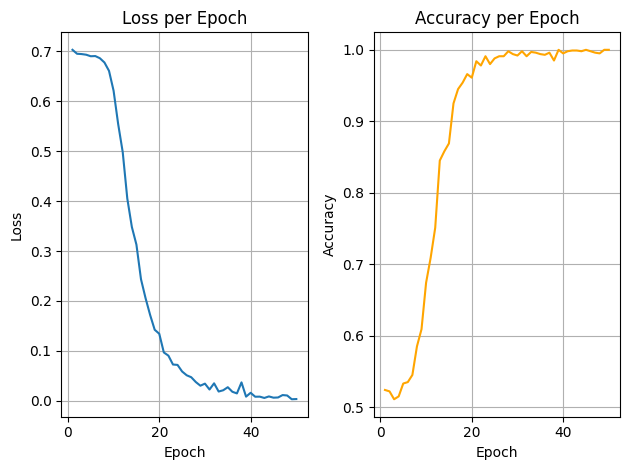

In [ ]:
import matplotlib.pyplot as plt

from torch.optim import SGD # import SGD

# 1. Définir et transférer le modèle
modelFF = FF_Model(vocab_size=vocab_size, embed_dim=100, hidden_dim=100, output_dim=2)  # Assurez-vous que vous définissez le bon vocabulaire et la bonne taille
modelFF.to(device)

# 2. Créer les DataLoaders pour le jeu d'entraînement et de test
dataloader_train = DataLoader(encoded_train, batch_size=4, shuffle=True)
dataloader_test = DataLoader(encoded_test, batch_size=4, shuffle=False)

for batch in dataloader_train:
    print(batch.keys())  # Imprime les clés disponibles dans chaque batch
    break  # Afficher uniquement le premier batch


# 3. Initialiser l'optimiseur et l'éventuel scheduler
optimizer_sgb = SGD(modelFF.parameters(), lr=0.01)  # Change to SGD optimizer
optimizer_adam = torch.optim.Adam(modelFF.parameters(), lr=0.001)
# 4. Entraîner le modèle
accs, loss = training(modelFF, dataloader_train, optimizer_adam, num_epochs=50)

# Plot de la perte
plt.subplot(1, 2, 1)
plt.plot(range(1, len(loss) + 1), loss, label="Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.grid(True)

# Plot de la précision
plt.subplot(1, 2, 2)
plt.plot(range(1, len(accs) + 1), accs, label="Accuracy", color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch')
plt.grid(True)

plt.tight_layout()
plt.show()


  0%|          | 0/250 [00:00<?, ?it/s]

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1: 1.0


  0%|          | 0/125 [00:00<?, ?it/s]

Accuracy: 0.78
Precision: 0.8192771084337349
Recall: 0.758364312267658
F1: 0.7876447876447876


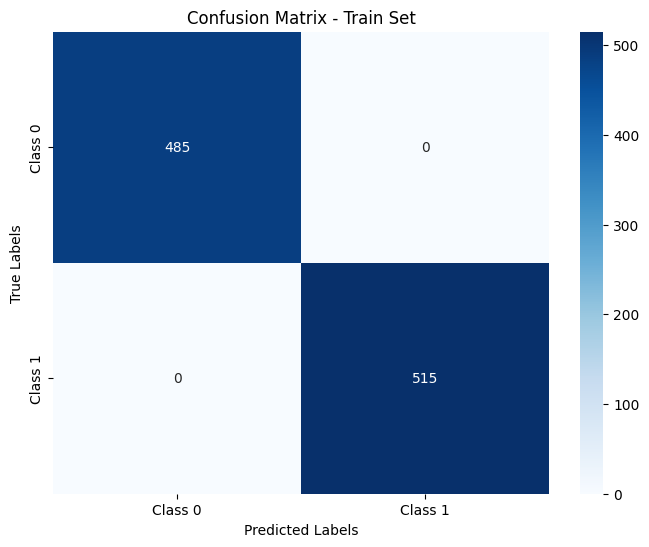

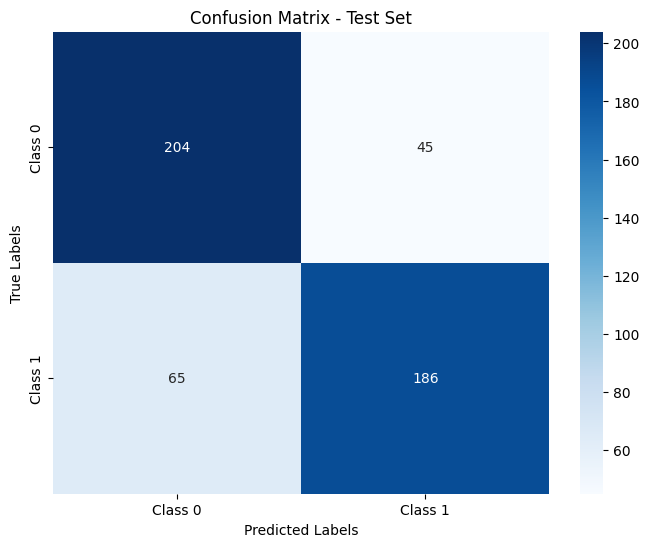

In [ ]:
# Evaluate and plot confusion matrices for train and test
gold_train, pred_train, conf_mat_train = evaluate_model(modelFF, dataloader_train)
gold_test, pred_test, conf_mat_test = evaluate_model(modelFF, dataloader_test)

# Plot confusion matrices
plot_confusion_matrix(conf_mat_train, title="Confusion Matrix - Train Set")
plot_confusion_matrix(conf_mat_test, title="Confusion Matrix - Test Set")

## Optionnel: comparaison avec un LSTM

**Remplacez le modèle FF par un LSTM qui définira un embedding pour chaque mot du vocabulaire (en utilisant cette fois le module nn.Embedding)**

Vous pouvez reprendre le squelette ci-dessous

In [ ]:
# LSTM
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

class LSTM_Model(nn.Module):
    def __init__(self, vocab_size, embed_dim, fc_hidden_dim, output_dim, lstm_hidden_dim, lstm_num_layers):
        super(LSTM_Model, self).__init__()
        # Embedding layer
        self.emb_layer = nn.Embedding(vocab_size, embed_dim)

        # LSTM layer
        self.lstm = nn.LSTM(embed_dim, lstm_hidden_dim, lstm_num_layers, batch_first=True)

        # Fully connected layer
        self.fc = nn.Linear(lstm_hidden_dim, fc_hidden_dim)

        # Output layer
        self.out = nn.Linear(fc_hidden_dim, output_dim)

        # Non-linearity
        self.relu = nn.ReLU()

    def forward(self, input):
        # Embedding lookup
        embedded = self.emb_layer(input)  # Shape: [batch_size, seq_len, embed_dim]

        # LSTM forward pass
        lstm_out, _ = self.lstm(embedded)  # Shape: [batch_size, seq_len, lstm_hidden_dim]

        # Take the final hidden state from the LSTM
        final_hidden_state = lstm_out[:, -1, :]  # Shape: [batch_size, lstm_hidden_dim]

        # Pass through fully connected layer and activation
        fc_out = self.relu(self.fc(final_hidden_state))  # Shape: [batch_size, fc_hidden_dim]

        # Output layer
        out = self.out(fc_out)  # Shape: [batch_size, output_dim]

        return out


dict_keys(['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'])


epoch:   0%|          | 0/50 [00:00<?, ?it/s]

batch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 0. Loss: 0.6954412035942078. ACC 0.507 


batch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 1. Loss: 0.6932789733409882. ACC 0.515 


batch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 2. Loss: 0.6930736684799195. ACC 0.515 


batch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 3. Loss: 0.6930886905193329. ACC 0.507 


batch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 4. Loss: 0.6930620956420899. ACC 0.516 


batch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 5. Loss: 0.6923551416397095. ACC 0.516 


batch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 6. Loss: 0.692455781698227. ACC 0.509 


batch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 7. Loss: 0.6921966540813446. ACC 0.516 


batch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 8. Loss: 0.6921622748374939. ACC 0.516 


batch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 9. Loss: 0.6921576552391052. ACC 0.516 


batch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 10. Loss: 0.6922057578563691. ACC 0.516 


batch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 11. Loss: 0.6922350919246674. ACC 0.516 


batch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 12. Loss: 0.6921457645893097. ACC 0.516 


batch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 13. Loss: 0.6922312849760055. ACC 0.516 


batch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 14. Loss: 0.6921499271392823. ACC 0.516 


batch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 15. Loss: 0.6922743865251542. ACC 0.516 


batch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 16. Loss: 0.6921631133556366. ACC 0.516 


batch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 17. Loss: 0.6921307756900787. ACC 0.516 


batch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 18. Loss: 0.692191596031189. ACC 0.516 


batch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 19. Loss: 0.6922209208011627. ACC 0.516 


batch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 20. Loss: 0.6921597940921783. ACC 0.516 


batch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 21. Loss: 0.6921263420581818. ACC 0.516 


batch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 22. Loss: 0.6921891512870788. ACC 0.516 


batch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 23. Loss: 0.6921547405719757. ACC 0.516 


batch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 24. Loss: 0.692141321182251. ACC 0.516 


batch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 25. Loss: 0.692280277967453. ACC 0.516 


batch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 26. Loss: 0.6922509388923646. ACC 0.516 


batch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 27. Loss: 0.6922914764881134. ACC 0.516 


batch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 28. Loss: 0.692259655714035. ACC 0.516 


batch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 29. Loss: 0.6921861841678619. ACC 0.516 


batch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 30. Loss: 0.6921442053318023. ACC 0.516 


batch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 31. Loss: 0.6921621129512787. ACC 0.516 


batch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 32. Loss: 0.6922064037322998. ACC 0.516 


batch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 33. Loss: 0.6922196033000946. ACC 0.516 


batch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 34. Loss: 0.6922375316619873. ACC 0.516 


batch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 35. Loss: 0.6922048246860504. ACC 0.516 


batch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 36. Loss: 0.69219269323349. ACC 0.516 


batch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 37. Loss: 0.6922223432064056. ACC 0.516 


batch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 38. Loss: 0.6922016353607178. ACC 0.516 


batch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 39. Loss: 0.6921351212263107. ACC 0.516 


batch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 40. Loss: 0.6922040486335754. ACC 0.516 


batch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 41. Loss: 0.6922847371101379. ACC 0.516 


batch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 42. Loss: 0.6921430747509003. ACC 0.516 


batch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 43. Loss: 0.6921535160541534. ACC 0.516 


batch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 44. Loss: 0.6921499247550964. ACC 0.516 


batch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 45. Loss: 0.6922674882411957. ACC 0.516 


batch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 46. Loss: 0.6921770114898682. ACC 0.516 


batch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 47. Loss: 0.6922631433010101. ACC 0.516 


batch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 48. Loss: 0.6921799840927124. ACC 0.516 


batch:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 49. Loss: 0.6921768929958344. ACC 0.516 


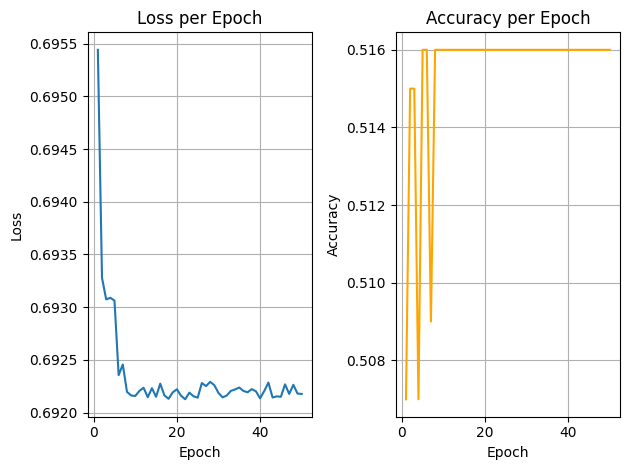

In [ ]:
import matplotlib.pyplot as plt

from torch.optim import SGD # import SGD

# 1. Définir et transférer le modèle
modelLSTM = LSTM_Model(vocab_size=vocab_size, embed_dim=100, fc_hidden_dim=100, output_dim=2, lstm_hidden_dim = 128 ,lstm_num_layers = 2)  # Assurez-vous que vous définissez le bon vocabulaire et la bonne taille
modelLSTM.to(device)

# 2. Créer les DataLoaders pour le jeu d'entraînement et de test
dataloader_train = DataLoader(encoded_train, batch_size=4, shuffle=True)
dataloader_test = DataLoader(encoded_test, batch_size=4, shuffle=False)

for batch in dataloader_train:
    print(batch.keys())  # Imprime les clés disponibles dans chaque batch
    break  # Afficher uniquement le premier batch


# 3. Initialiser l'optimiseur et l'éventuel scheduler
optimizer_sgb = SGD(modelLSTM.parameters(), lr=0.01)  # Change to SGD optimizer
optimizer_adam = torch.optim.Adam(modelLSTM.parameters(), lr=0.001)
# 4. Entraîner le modèle
accs, loss = training(modelLSTM, dataloader_train, optimizer_adam, num_epochs=50)

# Plot de la perte
plt.subplot(1, 2, 1)
plt.plot(range(1, len(loss) + 1), loss, label="Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.grid(True)

# Plot de la précision
plt.subplot(1, 2, 2)
plt.plot(range(1, len(accs) + 1), accs, label="Accuracy", color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch')
plt.grid(True)

plt.tight_layout()
plt.show()


# 3. Fine-tuning d'un modèle contextuel préentrainé

Cette fois on va juste continuer l'entrainement d'un modèle préentrainé, sur nos données spécifiques, en utilisant une librarie dédiée, huggingface, qui gère tout depuis la tokenization, entrainement et prédiction.

**Dans cette partie tout le code est déjà fonctionnel (sauf pour faire les prédictions sur le test), mais vous devez trouver les meilleurs choix de paramètres**

In [ ]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.5 MB/s eta 0:00:00


In [ ]:
import transformers
import evaluate
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import AutoModelForTokenClassification

In [ ]:
# plus prudent avec un petit modele, mais vous pouvez essayer avec bert-base-uncased aussi
base_model = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(base_model)
model = AutoModelForSequenceClassification.from_pretrained(base_model)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Différentes options peuvent être testées pour la tokenization.
**Regardez la doc du tokenizer pour éventuellement changer la stratégie de padding et de troncation, et dites si vous voyez des changements de résultats expérimentaux**

In [ ]:
# c'est ici qu'on définit ce qui sera effectivement passé en entrée du modèle à partir des instances du dataset
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)


tokenized_train_datasets = dataset_train.map(tokenize_function, batched=True)
tokenized_test_datasets = dataset_test.map(tokenize_function, batched=True)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Huggingface permet de définir une boucle d'entrainement à partir de certains paramètres de configuration.

Voici une base, **vous pouvez chercher des réglages différents**

https://huggingface.co/docs/transformers/main_classes/trainer



In [ ]:
from transformers import TrainingArguments, Trainer
training_args = TrainingArguments(output_dir="test_trainer",
                                  #no_cuda=False, # True sur ordi perso sans bon GPU
                                  per_device_train_batch_size=8,
                                  eval_strategy="epoch",
                                  report_to="none",
                                  num_train_epochs=1)

In [ ]:
# définition de la métrique d'éval
# NE RIEN MODIFIER ICI

# necessary for evaluation during training
metric = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_datasets,
    eval_dataset=tokenized_test_datasets,
    compute_metrics=compute_metrics,
)

In [ ]:
# necessary on colab -> NE RIEN MODIFIER ICI
# Tell the Trainer to not pin memory / caused by having the data already on GPU
training_args.dataloader_pin_memory = False

res = trainer.train()
print(res)

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.388148,0.846000


TrainOutput(global_step=125, training_loss=0.45603021240234376, metrics={'train_runtime': 66.338, 'train_samples_per_second': 15.074, 'train_steps_per_second': 1.884, 'total_flos': 132467398656000.0, 'train_loss': 0.45603021240234376, 'epoch': 1.0})


In [ ]:
# test predictions sur un exemple
inputs = tokenizer("This movie was so bad it was almost good.", return_tensors="pt").to(device)
outputs = model(**inputs)
# get the normalized scores
list(nn.Softmax(dim=1)(outputs.logits).detach().cpu().numpy()[0])

[0.93150866, 0.06849136]

In [ ]:
# get the most likely class
np.argmax(outputs.logits.detach().cpu(),axis=-1)

tensor([0])

On peut regarder les prédictions du modèles, et les scores assignées à chaque classe pour chaque instance:

In [ ]:
input_test = tokenized_test_datasets
predictions = trainer.predict(input_test)

In [ ]:
predictions.metrics

{'test_loss': 0.38814812898635864,
 'test_accuracy': 0.846,
 'test_runtime': 7.1673,
 'test_samples_per_second': 69.761,
 'test_steps_per_second': 8.79}

In [ ]:
predictions.predictions.shape

(500, 2)

In [ ]:
torch_logits = torch.from_numpy(predictions.predictions)
probabilities_scores = F.softmax(torch_logits,dim=1).numpy()

(array([[ 93.,  54.,  13.,  20.,  13.,   6.,   9.,   3.,   3.,   2.,   3.,
           5.,   3.,   5.,   6.,   5.,   4.,  15.,  29., 209.],
        [209.,  29.,  15.,   4.,   5.,   6.,   5.,   3.,   5.,   3.,   2.,
           3.,   3.,   9.,   6.,  13.,  20.,  13.,  54.,  93.]]),
 array([0.03364763, 0.08028287, 0.12691811, 0.17355333, 0.22018857,
        0.2668238 , 0.31345904, 0.36009428, 0.40672952, 0.45336476,
        0.5       , 0.54663521, 0.59327048, 0.63990569, 0.6865409 ,
        0.73317617, 0.77981138, 0.82644665, 0.87308186, 0.91971713,
        0.96635234]),
 <a list of 2 BarContainer objects>)

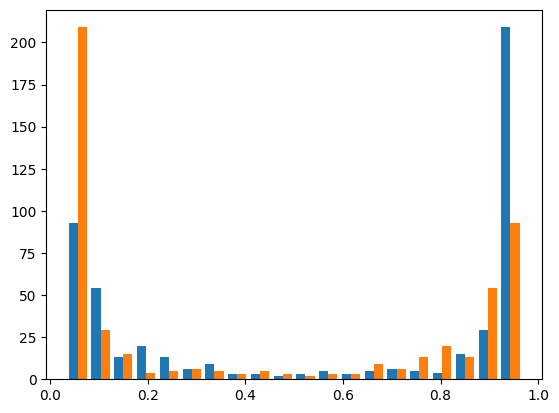

In [ ]:
plt.hist(probabilities_scores,20)

**Que peut-on dire des probablités des prédictions du modèle ?**

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.380897,0.854000
2,No log,0.366377,0.858000
3,No log,0.359361,0.854000
4,No log,0.359845,0.858000
5,No log,0.364598,0.864000
6,No log,0.367041,0.860000
7,0.192700,0.363793,0.864000
8,0.192700,0.367403,0.862000
9,0.192700,0.371182,0.862000
10,0.192700,0.372911,0.866000


Probabilités : [0.9459513  0.05404875]
Classe prédite : [0]


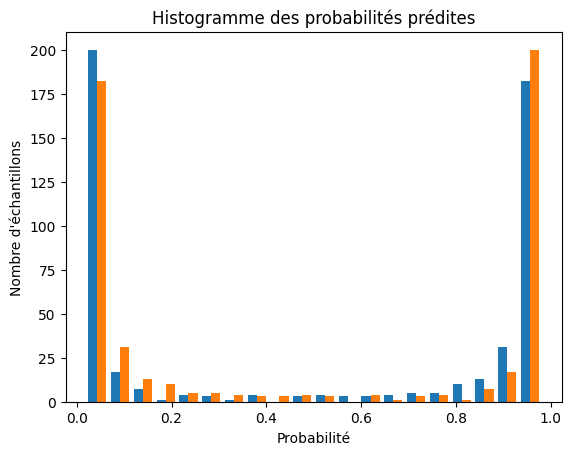

In [ ]:
# Définir les arguments d'entraînement avec des paramètres ajustés
training_args = TrainingArguments(
    output_dir="test_trainer",
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="steps",
    logging_steps=50,
    report_to="none",
    num_train_epochs=10,
    learning_rate=3e-5,
    weight_decay=0.01,
    warmup_steps=500,
    lr_scheduler_type="linear",
    fp16=True,  # Activation de la précision mixte si supportée par le GPU
    gradient_accumulation_steps=2,
    metric_for_best_model="accuracy",
    load_best_model_at_end=True
)

# Charger la métrique d'évaluation
metric = evaluate.load("accuracy")

# Fonction pour calculer les métriques d'évaluation
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

# Créer le Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_datasets,
    eval_dataset=tokenized_test_datasets,
    compute_metrics=compute_metrics,
)

# Nécessaire sur Colab pour éviter les problèmes de mémoire
training_args.dataloader_pin_memory = False

# Entraîner le modèle
trainer.train()

# Déplacer le modèle sur le bon appareil (CPU ou GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Test des prédictions sur un exemple
inputs = tokenizer("This movie was so bad it was almost good.", return_tensors="pt").to(device)
outputs = model(**inputs)

# Obtenir les scores normalisés (probabilités)
probs = torch.nn.Softmax(dim=1)(outputs.logits).detach().cpu().numpy()[0]
print("Probabilités :", probs)

# Obtenir la classe prédite la plus probable
predicted_class = np.argmax(outputs.logits.detach().cpu().numpy(), axis=-1)
print("Classe prédite :", predicted_class)

# Générer les prédictions sur le jeu de test
predictions = trainer.predict(tokenized_test_datasets)

# Extraire les probabilités des prédictions
torch_logits = torch.from_numpy(predictions.predictions)
probabilities_scores = F.softmax(torch_logits, dim=1).numpy()

# Tracer l'histogramme des probabilités
plt.hist(probabilities_scores, bins=20)
plt.title("Histogramme des probabilités prédites")
plt.xlabel("Probabilité")
plt.ylabel("Nombre d'échantillons")
plt.show()

### **Conclusion**




Cette distribution indique que le modèle affiche une grande confiance dans ses prédictions. Cela peut être interprété comme un signe encourageant, à condition que cette confiance soit justifiée par une précision élevée des résultats. Une telle certitude peut refléter un bon apprentissage des données, mais il est également essentiel de vérifier qu'elle ne résulte pas d'un surapprentissage ou d'une biais systématique dans les données. En d'autres termes, une validation rigoureuse des performances est nécessaire pour confirmer que cette confiance est bien fondée et qu'elle se traduit par des prédictions fiables dans des contextes variés.